<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MLP-vs.-CNN" data-toc-modified-id="MLP-vs.-CNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MLP vs. CNN</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Build-a-MLP-model" data-toc-modified-id="Build-a-MLP-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build a MLP model</a></span></li><li><span><a href="#Train-the-MLP-with-images" data-toc-modified-id="Train-the-MLP-with-images-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train the MLP with images</a></span></li><li><span><a href="#Test-the-final-MLP-on-training-data" data-toc-modified-id="Test-the-final-MLP-on-training-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test the final MLP on training data</a></span></li><li><span><a href="#Testing-the-MLP-with-new-images" data-toc-modified-id="Testing-the-MLP-with-new-images-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Testing the MLP with new images</a></span></li><li><span><a href="#Conclusions-for-the-MLP" data-toc-modified-id="Conclusions-for-the-MLP-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusions for the MLP</a></span></li><li><span><a href="#Build-a-CNN" data-toc-modified-id="Build-a-CNN-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Build a CNN</a></span></li><li><span><a href="#Train-the-CNN" data-toc-modified-id="Train-the-CNN-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Train the CNN</a></span></li><li><span><a href="#Test-the-CNN-on-training-data" data-toc-modified-id="Test-the-CNN-on-training-data-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Test the CNN on training data</a></span></li><li><span><a href="#Test-the-CNN-on-new-images" data-toc-modified-id="Test-the-CNN-on-new-images-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Test the CNN on new images</a></span></li></ul></div>

# MLP vs. CNN

The goal of this notebook is to show by simple means that a CNN is a much better model than a MLP for image classification due to its capability to establish representations of the image in the feature hierarchy that are invariant to translations.

# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2

print( "Your NumPy version is: " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is: " + keras.__version__ )
print( "Your OpenCV version is: " + cv2.__version__ )

Your NumPy version is: 1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is: 2.2.4
Your OpenCV version is: 4.1.0


Using TensorFlow backend.


# Prepare an image provider class

In [26]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (100,100)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_training_items = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder", root_folder,
              "I found the following subfolders/classes:")
        print(class_names)
        
        self.nr_classes = len(class_names)
        
        # For each subfolder ...
        for class_id, class_name in enumerate(class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            # For each image filename in current subfolder ...
            for filename in filenames:
                
                teacher_vec = np.zeros( self.nr_classes )
                teacher_vec[class_id] = 1.0
                
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available.".format(self.nr_images))
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # invert image
        image = 255 - image
        
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.get_specific_image( rnd_idx )


Let's test the image provider class:

In [27]:
my_image_provider = image_provider( "data_digits" )

Under folder data_digits I found the following subfolders/classes:
['1', '2']
10 files in subfolder data_digits/1/
10 files in subfolder data_digits/2/
There are 20 images in total available.


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (100, 100, 3)
teacher vec: [1. 0.]


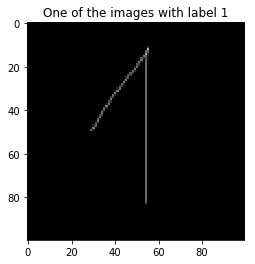

In [28]:
import matplotlib.pyplot as plt

image, class_id, class_name, teacher_vec = \
    my_image_provider.get_random_image()
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(class_name))
plt.show()

# Build a MLP model

In [103]:
from keras.models import Sequential
from keras import layers
from keras.layers.core import Dense
from keras import backend as K

nr_channels = 3
input_vec_dim = IMG_SIZE[0] * IMG_SIZE[1] * nr_channels
print("Input vectors for this MLP will have length", input_vec_dim)

def build_mlp_model():
    
    np.random.seed( 42 )
    
    K.clear_session()
    
    model = Sequential()
    model.add(Dense(10, activation="relu", input_dim=input_vec_dim))
    model.add(Dense(2, activation="linear"))

    model.summary()

    model.compile(loss='mean_squared_error', optimizer='sgd')
    
    return model

my_mlp = build_mlp_model()

Input vectors for this MLP will have length 30000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                300010    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 300,032
Trainable params: 300,032
Non-trainable params: 0
_________________________________________________________________


# Train the MLP with images

First let us define a helper function ``train_model`` that can train a model / image provider combination that is specified.

In [104]:
def transform_image_to_model_specific_input(model_type, image):
    
    # Prepare model specific input
    if model_type=="mlp":

        # the input for a MLP has to be a 2D array

        # Flatten the 3D input image to a 1D input vector
        input_vec = image.flatten()

        #print("image has shape", image.shape)
        #print("input_vec has shape", input_vec.shape)
        #print("teacher_vec is", teacher_vec)
        #print(input_vec)

        # now prepare a 2D array
        X = input_vec.reshape( (1, input_vec.shape[0]) )

    elif model_type=="cnn":

        # put the image into a 4D array
        # note: Keras expects a 4D array as input for
        #       the training function fit() if the model is a CNN

        height = image.shape[0]
        width  = image.shape[1]
        nr_channels = image.shape[2]
        X = np.zeros( (1,height,width,nr_channels) )

        X[0,:,:,:] = image
        
    return X


def train_model(model_type, your_model, your_image_provider, nr_train_images):

    for train_img_idx in range(0,nr_train_images):

        if train_img_idx % 500 == 0:
            print("Trained on {} images so far...".
                 format(train_img_idx))

        # Get a random image from the image provider
        image, class_id, class_name, teacher_vec = \
            your_image_provider.get_random_image()

        # Show the training image?
        if False:
            plt.imshow(image)
            plt.title("Training image with label {}".format(class_name))
            plt.show()
        
        X = transform_image_to_model_specific_input(model_type, image)

        # the teacher value array expected by Keras
        # is a 2D array        
        Y = teacher_vec.reshape( (1, teacher_vec.shape[0]) )

        your_model.fit(X, Y, epochs=1, verbose=0)

    print("Training finished!")

Now let us train the MLP generated before:

In [105]:
train_model( "mlp", my_mlp, my_image_provider, 5000 )

Trained on 0 images so far...
Trained on 500 images so far...
Trained on 1000 images so far...
Trained on 1500 images so far...
Trained on 2000 images so far...
Trained on 2500 images so far...
Trained on 3000 images so far...
Trained on 3500 images so far...
Trained on 4000 images so far...
Trained on 4500 images so far...
Training finished!


# Test the final MLP on training data

Now let us see how good the trained MLP performs on the same data on which we trained it: the training data.

For this, we will define a test function that tests the specified model on the specified (training) data set.

In [106]:
def test_model_on_train_data(model_type, your_model, your_image_provider):

    # No images correctly classified so far
    correctly_classified = 0

    for img_idx in range(0, your_image_provider.nr_images):

        print("\nTesting with training image {}".
                 format(img_idx))

        # Get image from image provider
        image, gt_class_id, gt_class_name, teacher_vec = \
            your_image_provider.get_specific_image( img_idx )

        X = transform_image_to_model_specific_input(model_type, image)

        # Let the MLP predict the class!
        neuron_outputs = your_model.predict( X )
        print("output neuron values are:", neuron_outputs)

        # Get final prediction result:
        # Which of the n output neurons has the largest output?
        predicted_class_id = np.argmax(neuron_outputs.reshape(-1))

        # Show comparison of predicted vs. ground-truth label
        print("predicted: {} vs. real: {}".
              format(predicted_class_id, gt_class_id))

        # Compute correct classification rate
        if predicted_class_id==gt_class_id:
            correctly_classified += 1

    print("\n---\nCorrectly classified {} of {} images.".
          format(correctly_classified, my_image_provider.nr_images))

And now the test how good the trained MLP can classify the training data images:

In [107]:
test_model_on_train_data("mlp", my_mlp, my_image_provider)


Testing with training image 0
output neuron values are: [[1.000000e+00 7.450581e-09]]
predicted: 0 vs. real: 0

Testing with training image 1
output neuron values are: [[ 1.0000000e+00 -3.7252903e-09]]
predicted: 0 vs. real: 0

Testing with training image 2
output neuron values are: [[1.0000000e+00 1.8626451e-08]]
predicted: 0 vs. real: 0

Testing with training image 3
output neuron values are: [[1.0000000e+00 3.7252903e-09]]
predicted: 0 vs. real: 0

Testing with training image 4
output neuron values are: [[1.0000000e+00 3.7252903e-09]]
predicted: 0 vs. real: 0

Testing with training image 5
output neuron values are: [[ 1.0000000e+00 -3.7252903e-09]]
predicted: 0 vs. real: 0

Testing with training image 6
output neuron values are: [[ 1.0000000e+00 -3.7252903e-09]]
predicted: 0 vs. real: 0

Testing with training image 7
output neuron values are: [[ 1.0000000e+00 -2.2351742e-08]]
predicted: 0 vs. real: 0

Testing with training image 8
output neuron values are: [[1.0000000e+00 4.8428774

# Testing the MLP with new images

In order to generate new test images, we just shift the digits some pixels to the right.

In [112]:
def test_model_on_new_data(model_type,
                           your_model,
                           your_image_provider,
                           nr_test_images):

    # No images correctly classified so far
    correctly_classified = 0

    for test_img_idx in range(0,nr_test_images):

        if test_img_idx % 100 == 0:
            print("Tested on {} test images so far...".
                 format(test_img_idx))

        # Get a random image from the image provider
        image, gt_class_id, gt_class_name, teacher_vec = \
            your_image_provider.get_random_image()

        # Shift this original image a little bit to the right
        # in order to generate a new random image
        image2 = np.zeros( image.shape )
        MIN_SHIFT = 5
        MAX_SHIFT = 15
        rnd_shiftx = np.random.randint(MIN_SHIFT, MAX_SHIFT)
        rnd_shifty = np.random.randint(MIN_SHIFT, MAX_SHIFT)
        nr_rows = image.shape[0]
        nr_cols = image.shape[1]
        for row_idx in range(rnd_shifty, nr_rows):
            for col_idx in range(rnd_shiftx, nr_cols):
                image2[row_idx][col_idx] =\
                    image[row_idx-rnd_shifty][col_idx-rnd_shiftx]

        # Show the original and the new image?
        # Only for the first 3 test images, else:
        # too much output!
        if test_img_idx < 3:
            print("\nTest image: {}".format(test_img_idx))
            plt.imshow(image)
            plt.title("Original image with label {}".format(gt_class_name))
            plt.show()
            plt.imshow(image2)
            plt.title("Automatically generated test image with label {}".
                      format(gt_class_name))
            plt.show()
            
        X = transform_image_to_model_specific_input(model_type, image2)
        
        # Let the MLP predict the class!
        neuron_outputs = your_model.predict( X )
        #print("output neuron values are:", neuron_outputs)

        # Get final prediction result:
        # Which of the n output neurons has the largest output?
        predicted_class_id = \
            np.argmax(neuron_outputs.reshape(-1))

        # Show comparison of predicted vs. ground-truth label
        #print("predicted: {} vs. real: {}".
        #      format(predicted_class_id, gt_class_id))

        # Compute correct classification rate
        if predicted_class_id==gt_class_id:
            correctly_classified += 1

    print("\n---\nCorrectly classified {} of {} images.".
          format(correctly_classified, nr_test_images))

And now the final interesting test: how good can the MLP classify new images? (where the new images are just shifted versions of the original images)

Tested on 0 test images so far...

Test image: 0


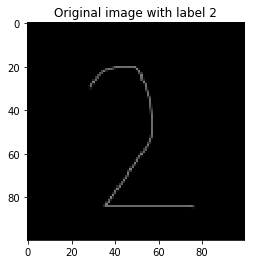

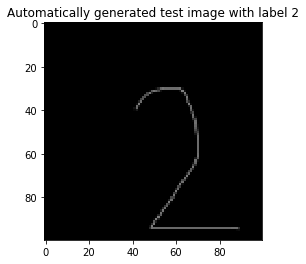


Test image: 1


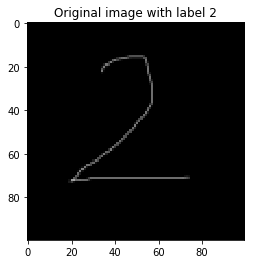

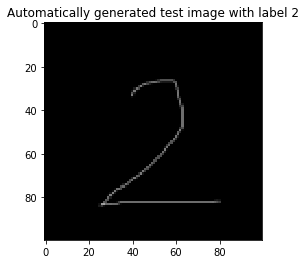


Test image: 2


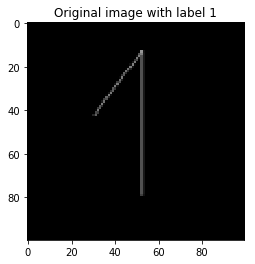

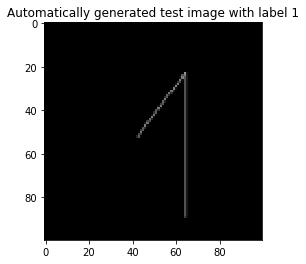

Tested on 100 test images so far...
Tested on 200 test images so far...
Tested on 300 test images so far...
Tested on 400 test images so far...
Tested on 500 test images so far...
Tested on 600 test images so far...
Tested on 700 test images so far...
Tested on 800 test images so far...
Tested on 900 test images so far...

---
Correctly classified 504 of 1000 images.


In [113]:
test_model_on_new_data("mlp", my_mlp, my_image_provider, 1000)

# Conclusions for the MLP

The test of this MLP for image classification shows.

It performs perfectly on the training data, since it used it huge sets of parameters to directly map the few input images to the desired output values.

However, on new images (just translated variants of the original image), the MLP is not besser than randomly guessing the class of the image.

By this we show that image classification with a MLP is not a good idea. Instead, we need another model that is able to come up with a representation of the image that is (mostly) invariant to translations (and all the other transformations, e.g. rotation).

This will lead us to Convolutional Neural Networks (CNN).


# Build a CNN

Now we build a CNN which has a feature hierarchy before the MLP part. And this feature hierarchy should help to map the pixel-representation of the image to a feature-representation of the image which is more translation-invariant.

Let us see whether this really works as supposed to, i.e., can a CNN classify new images better compared to a MLP? (where we use the same 20 training images for training the CNN)

In [159]:
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K

image, class_id, class_name, teacher_vec = my_image_provider.get_random_image()
input_shape_of_single_image = image.shape

def build_cnn_model():
    
    np.random.seed( 42 )
    
    K.clear_session()

    model = Sequential()
    
    # Layer 1
    nr_filter       = 16
    kernel_side_len = 5
    kernel_stride   = 2
    model.add(Conv2D(nr_filter,
                     kernel_size=(kernel_side_len, kernel_side_len),
                     strides=(kernel_stride, kernel_stride),
                     activation='relu',
                     input_shape=input_shape_of_single_image)
             )
    
    # Layer 2
    kernel_side_len = 3
    kernel_stride   = 3
    model.add(MaxPooling2D(pool_size=(kernel_side_len, kernel_side_len),
                           strides=(kernel_stride, kernel_stride))
             )
    
    # Layer 3
    nr_filter       = 32
    kernel_side_len = 5
    kernel_stride   = 2
    model.add(Conv2D(nr_filter,
                     kernel_size=(kernel_side_len, kernel_side_len),
                     strides=(kernel_stride, kernel_stride),
                     activation='relu',
                     input_shape=input_shape_of_single_image)
             )
    
    # Layer 4
    kernel_side_len = 4
    kernel_stride   = 4
    model.add(MaxPooling2D(pool_size=(kernel_side_len, kernel_side_len),
                           strides=(kernel_stride, kernel_stride))
             )
    
    # 2. Define the MLP part:
    model.add(Flatten())
    #model.add(Dense(10, activation="relu"))
    model.add(Dense(2, activation="linear"))

    model.summary()

    model.compile(loss='mean_squared_error', optimizer='sgd')
    
    return model

my_cnn = build_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 14,114
Trainable params: 14,114
Non-trainable params: 0
_________________________________________________________________


# Train the CNN

In [160]:
train_model("cnn", my_cnn, my_image_provider, 1000)

Trained on 0 images so far...
Trained on 500 images so far...
Training finished!


# Test the CNN on training data

In [161]:
test_model_on_train_data("cnn", my_cnn, my_image_provider)


Testing with training image 0
output neuron values are: [[ 0.98310363 -0.00348513]]
predicted: 0 vs. real: 0

Testing with training image 1
output neuron values are: [[1.021631   0.01477545]]
predicted: 0 vs. real: 0

Testing with training image 2
output neuron values are: [[9.497481e-01 7.094741e-04]]
predicted: 0 vs. real: 0

Testing with training image 3
output neuron values are: [[1.0009774  0.00863144]]
predicted: 0 vs. real: 0

Testing with training image 4
output neuron values are: [[1.0086279  0.01171935]]
predicted: 0 vs. real: 0

Testing with training image 5
output neuron values are: [[0.9954561  0.02513446]]
predicted: 0 vs. real: 0

Testing with training image 6
output neuron values are: [[ 0.9745147  -0.00304782]]
predicted: 0 vs. real: 0

Testing with training image 7
output neuron values are: [[ 0.9672529  -0.01353386]]
predicted: 0 vs. real: 0

Testing with training image 8
output neuron values are: [[0.9799966  0.00099379]]
predicted: 0 vs. real: 0

Testing with trai

# Test the CNN on new images

Tested on 0 test images so far...

Test image: 0


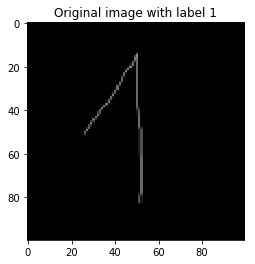

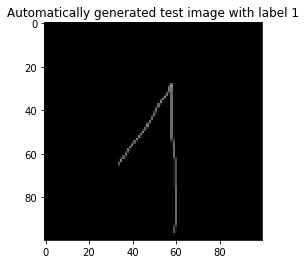


Test image: 1


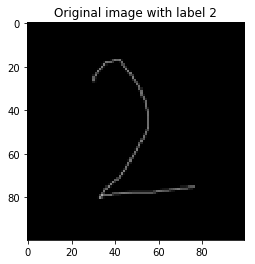

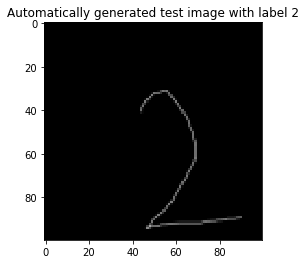


Test image: 2


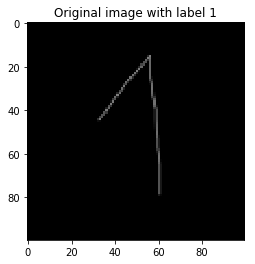

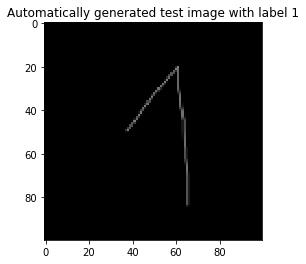

Tested on 100 test images so far...
Tested on 200 test images so far...
Tested on 300 test images so far...
Tested on 400 test images so far...
Tested on 500 test images so far...
Tested on 600 test images so far...
Tested on 700 test images so far...
Tested on 800 test images so far...
Tested on 900 test images so far...

---
Correctly classified 917 of 1000 images.


In [163]:
test_model_on_new_data("cnn", my_cnn, my_image_provider, 1000)